In [2]:
import os
import pandas as pd
import numpy as np
import itertools
from string import ascii_uppercase
import re
from time import time

from pycytominer.operations.transform import Spherize
from pycytominer.operations.transform import RobustMAD

from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from rdkit import Chem

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

def get_cp_embeddings(selected_metadata):
    """Get CP raw embeddings

    :param selected_metadata: pd.DataFrame
        DataFrame that contains metadata [Metadata_Source, Metadata_Batch, Metadata_Plate]

    :return
        Dataframe with raw CP embeddings
    """

    profile_formatter = (
        "s3://cellpainting-gallery/cpg0016-jump/"
        "{Metadata_Source}/workspace/profiles/"
        "{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet"
    )
    _dframes = pd.DataFrame()
    for _, row in selected_metadata.iterrows():
        plate_name = row["Metadata_Plate"]
        if not os.path.exists(f"./jump_cp_target2/{plate_name}.parquet"):
            s3_path = profile_formatter.format(**row.to_dict())
            df = pd.read_parquet(s3_path, storage_options={"anon": True})
            df.to_parquet(f"./jump_cp_target2/{plate_name}.parquet")
        else:
            df = pd.read_parquet(f"./jump_cp_target2/{plate_name}.parquet")
        _dframes = pd.concat([_dframes, df], axis=0, ignore_index=True)
    return _dframes


def drop_bad_columns(df, feature_cols=None):
    """Drop bad CP embeddings dimensions

    :param df: pd.DataFrame
        DataFrame that contains CP embeddings
    :param cols: List[str]
        List of column names that indicate CP features

    :return
        Dataframe with clean raw CP embeddings
    """

    if not feature_cols:
        feature_cols = [c for c in df.columns if "Metadata_" not in c]
    stdev = [df[c].std() for c in feature_cols]

    cols_to_drop = []
    cols_to_drop.extend([feature_cols[i] for i, s in enumerate(stdev) if s < 0.1 or s > 10])
    #cols_to_drop.extend([feature_cols[i] for i, s in enumerate(stdev) if s == 0])

    df = df[[c for c in df.columns if c not in cols_to_drop]]
    return df


def robustMAD(df, feature_cols, control_only=False):
    """MAD robust

    :param df: pd.DataFrame
        DataFrame that contains CP embeddings
    :param feature_cols: List[str]
        List of column names that indicate features
    :param control_only: bool
        processing agains control images only / full dataset

    :return
        Dataframe with processed raw CP embeddings
    """

    if not control_only:
        feature_df = df.loc[:, feature_cols]
    else:
        feature_df = df.query('`Metadata_JCP2022` == "JCP2022_033924" | `Metadata_JCP2022` == "JCP2022_999999"').loc[:, feature_cols]
        if len(feature_df) == 0:
            feature_df = df.query('`Metadata_SMILES` == "CS(C)=O"').loc[:, feature_cols]
            if len(feature_df) == 0:
                print("No control samples found. Fall back to full normailization")
                feature_df = df.loc[:, feature_cols]
            feature_df = df.loc[:, feature_cols]
    rmad = RobustMAD()
    rmad.fit(feature_df)
    return rmad.transform(df.loc[:, feature_cols])


def spherize(df, feature_cols, control_only=False):
    """Spherizing

    :param df: pd.DataFrame
        DataFrame that contains CP embeddings
    :param feature_cols: List[str]
        List of column names that indicate features
    :param control_only: bool
        processing agains control images only / full dataset

    :return
        Dataframe with processed raw CP embeddings
    """

    if not control_only:
        feature_df = df.loc[:, feature_cols]
    else:
        feature_df = df.query('`Metadata_JCP2022` == "JCP2022_033924" | `Metadata_JCP2022` == "JCP2022_999999"').loc[:, feature_cols]
        if len(feature_df) == 0:
            feature_df = df.query('`Metadata_SMILES` == "CS(C)=O"').loc[:, feature_cols]
            if len(feature_df) == 0:
                print("No control samples found. Fall back to full normalization")
                feature_df = df.loc[:, feature_cols]
            feature_df = df.loc[:, feature_cols]
    spherize = Spherize()
    spherize.fit(feature_df)
    return spherize.transform(df.loc[:, feature_cols])


# Batch-wise process

def batch_wise_spherize_and_normalize(df, batch_col="Metadata_Source", feature_cols=None,
                                      is_spherize=True, is_normalize=True, control_only=False):
    """Mad robust + spherizing

    :param df: pd.DataFrame
        DataFrame that contains CP embeddings
    :param batch_col: str
        Hue indicating the batch columns
    :param feature_cols: List[str]
        List of column names that indicate features
    :param is_spherize: bool
        Whether to spherize
    :param is_normalize: bool
        Wheter to MAD robust
    :param control_only: bool
        processing agains control images only / full dataset

    :return
        Dataframe with processed raw CP embeddings
    """

    _df = df.copy(deep=True)
    if not feature_cols:
        feature_cols = [c for c in df.columns if not c.startswith('Metadata_')]
    for batch in _df[batch_col].unique():
        batch_df = _df.loc[_df[batch_col] == batch].copy(deep=True)
        if is_normalize:
            batch_df.loc[:, feature_cols] = robustMAD(batch_df, feature_cols=feature_cols, control_only=control_only)
        _df.loc[_df[batch_col] == batch] = batch_df.copy(deep=True)
    if is_spherize:
        _df.loc[:, feature_cols] = spherize(_df, feature_cols=feature_cols, control_only=control_only)
    return _df


def pca_embeddings(df, n_components=50, control_only=False):
    pca_model = PCA(n_components=n_components)
    metadata_cols = [c for c in df.columns if c.startswith('Metadata_')]
    feature_cols = [c for c in df.columns if not c.startswith('Metadata_')]

    _df = df.loc[:, metadata_cols].copy(deep=True)

    if not control_only:
        feature_df = df.loc[:, feature_cols]
    else:
        feature_df = df.query('`Metadata_JCP2022` == "JCP2022_033924" | `Metadata_JCP2022` == "JCP2022_999999"').loc[:,
                     feature_cols]
        if len(feature_df) == 0:
            feature_df = df.query('`Metadata_SMILES` == "CS(C)=O"').loc[:, feature_cols]
            if len(feature_df) == 0:
                print("No control samples found. Fall back to full normalization")
                feature_df = df.loc[:, feature_cols]
    pca_model.fit(feature_df)
    pca_features = pd.DataFrame(pca_model.transform(df.loc[:, feature_cols]),
                                columns=["pca_" + str(i) for i in np.arange(n_components)])
    _df = pd.concat([_df, pca_features], axis=1)

    return _df


def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_uppercase, repeat=size):
            yield "".join(s)


In [3]:
GIT_CLONE_DIR = "../MICON_dataset/datasets"
plates = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/plate.csv.gz"))
wells = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/well.csv.gz"))
compound = pd.read_csv(os.path.join(GIT_CLONE_DIR, "metadata/compound.csv"))
sources = np.unique(wells['Metadata_Source'].tolist())

outdir = "./feature_distances/cellprofiler_sphereMAD_pca/"
if not os.path.exists(outdir):
    os.makedirs(outdir)

filtered_sources = []
for source in sources:
    curr_compounds = np.unique(wells[wells['Metadata_Source'] == source]['Metadata_JCP2022'].tolist())
    if len(curr_compounds) > 50000:
        filtered_sources.append(source)

batches = plates[plates['Metadata_PlateType'] == 'TARGET2']['Metadata_Source'] + \
          "&" + plates[plates['Metadata_PlateType'] == 'TARGET2']['Metadata_Batch']
batches = np.unique(batches.tolist())

well_alpha_dict = {}
count = 0
for s in iter_all_strings():
    well_alpha_dict[s] = count
    count += 1
    if s == 'ZZ':
        break

for b in batches:
    batch_start_time = time()
    curr_source = b.split("&")[0]

    curr_batch = b.split("&")[1]
    print (curr_batch)
    curr_plates = plates[plates['Metadata_PlateType'] == 'TARGET2'][
        plates['Metadata_Source'] == curr_source][
        plates['Metadata_Batch'] == curr_batch]

    curr_outfn = outdir + curr_source + ".tsv"
    output = open(curr_outfn, "a")

    # Get features
    features = get_cp_embeddings(curr_plates)
    metadata_cols = [c for c in features.columns if c.startswith("Metadata_")]
    intensity_cols = [c for c in features.columns if c.startswith("Image_")]
    orig_features = features.loc[:, metadata_cols + intensity_cols].copy(deep=True)

    features = drop_bad_columns(features)
    features = features.replace([np.inf, -np.inf], np.nan).dropna(axis=1)   # Drop nan/inf
    features = features.merge(wells, on=["Metadata_Source", "Metadata_Plate", "Metadata_Well"])
    features = features.merge(compound, on=['Metadata_JCP2022'])

    smiles = []
    for inchi in features['Metadata_InChI'].tolist():
        try:
            smi = Chem.MolToSmiles(Chem.MolFromInchi(well['Metadata_InChI']))
        except:
            smi = "NA"
        smiles.append(smi)
    features['Metadata_SMILES'] = smiles

    tmp_df = features.query('`Metadata_JCP2022` == "JCP2022_033924" | `Metadata_JCP2022` == "JCP2022_999999"')
    if len(tmp_df) == 0:
        print ("Skipping", curr_batch,"- no controls found")
    else:
        print ("Working on ", curr_batch)
        features = batch_wise_spherize_and_normalize(features, control_only=False)
        print ("Fitting PCA model...")
        pca_features = pca_embeddings(features, control_only=False)

        print ("Matching pertubations to controls...")
        unique_plates = np.unique(features['Metadata_Plate'].tolist())
        for p in unique_plates:
            plate_start_time = time()
            curr_plate_features = features[features['Metadata_Plate'] == p]
            curr_plate_features_orig = orig_features[orig_features['Metadata_Plate'] == p]
            curr_plate_features_pca = pca_features[pca_features['Metadata_Plate'] == p]
            feature_cols = [c for c in curr_plate_features.columns if not c.startswith('Metadata_')]
            feature_pca_cols = [c for c in curr_plate_features_pca.columns if not c.startswith('Metadata_')]
            well_ids = curr_plate_features['Metadata_Well'].tolist()

            # Well to position mapping
            conv_dict = {}
            reverse_conv_dict = {}
            for w in well_ids:
                curr_id = [x for x in re.split('(\d+)', w) if x != '']
                curr_id[0] = well_alpha_dict[curr_id[0]]
                curr_id[1] = int(curr_id[1])
                conv_dict[w] = curr_id
                reverse_conv_dict[str(curr_id[0]) + "&" + str(curr_id[1])] = w

            # Get which positions are controls
            control_ids = curr_plate_features[curr_plate_features['Metadata_JCP2022'] ==
                                              "JCP2022_033924"]['Metadata_Well'].tolist()
            control_ids = [conv_dict[x] for x in control_ids]
            add_control_ids = curr_plate_features[curr_plate_features['Metadata_JCP2022'] ==
                                              "JCP2022_999999"]['Metadata_Well'].tolist()
            add_control_ids = [conv_dict[x] for x in add_control_ids]
            control_ids = np.array(control_ids + add_control_ids)

            # Iterate through non-DMSO
            for well in curr_plate_features.iterrows():
                well = well[1]
                if well['Metadata_JCP2022'] != "JCP2022_033924" and well['Metadata_JCP2022'] != "JCP2022_999999":
                    curr_well_id = well["Metadata_Well"]
                    closest_control_index = np.argmin(pairwise_distances([conv_dict[curr_well_id]], control_ids)[0])
                    control_well = reverse_conv_dict[str(control_ids[closest_control_index][0]) +
                                                     "&" + str(control_ids[closest_control_index][1])]

                    orig_well_features = curr_plate_features_orig[curr_plate_features_orig['Metadata_Well'] == curr_well_id].iloc[0]
                    well_AGP_area = orig_well_features['Image_ImageQuality_StdIntensity_OrigAGP']
                    well_DNA_area = orig_well_features['Image_ImageQuality_StdIntensity_OrigDNA']


                    curr_well_features = well[feature_cols].loc[feature_cols].to_numpy()
                    curr_control_features = curr_plate_features[curr_plate_features['Metadata_Well']
                                                                == control_well].iloc[0].loc[feature_cols].to_numpy()

                    curr_well_features_pca = curr_plate_features_pca[curr_plate_features_pca['Metadata_Well']
                                                                        == curr_well_id].iloc[0].loc[feature_pca_cols].to_numpy()
                    curr_control_features_pca = curr_plate_features_pca[curr_plate_features_pca['Metadata_Well']
                                                                        == control_well].iloc[0].loc[feature_pca_cols].to_numpy()

                    try:
                        euclid_dist = pairwise_distances([curr_well_features],
                                                         [curr_control_features],
                                                         metric="euclidean")[0][0]
                        cosine_dist = pairwise_distances([curr_well_features],
                                                         [curr_control_features],
                                                         metric="cosine")[0][0]

                        euclid_dist_pca = pairwise_distances([curr_well_features_pca],
                                                         [curr_control_features_pca],
                                                         metric="euclidean")[0][0]
                        cosine_dist_pca = pairwise_distances([curr_well_features_pca],
                                                         [curr_control_features_pca],
                                                         metric="cosine")[0][0]

                        try:
                            smi = Chem.MolToSmiles(Chem.MolFromInchi(well['Metadata_InChI']))
                        except:
                            smi = "NA"

                        output.write(str(well['Metadata_Plate']) + "\t" + str(well['Metadata_Source']) + "\t" +
                                     curr_batch + "\t" + str(well['Metadata_JCP2022']) + "\t"
                                     + str(well['Metadata_InChI']) + "\t" + str(well['Metadata_InChIKey']) + "\t"
                                     + str(smi) + "\t" + curr_batch + "\t" +
                                     curr_well_id + "\t" + control_well + "\t" + str(euclid_dist) + "\t" + str(cosine_dist)
                                     + "\t" + str(euclid_dist_pca) + "\t" + str(cosine_dist_pca)
                                     + "\t" + str(well_AGP_area) + "\t" + str(well_DNA_area) + "\n")
                    except ValueError:
                        pass

            print ("Finished plate", p, "in", time() - plate_start_time)
        print ("Finished batch", b, "in", time() - batch_start_time)



2021_08_03_U2OS_48_hr_run12
Working on  2021_08_03_U2OS_48_hr_run12


KeyboardInterrupt: 

source_10: Total 6 batchs, 6 plates
Dest210726-160150
Dest210803-153958
Dest210809-134534
Dest210823-172450
source_11: Total 4 batchs, 7 plates
LM37-70_1
LM37-70_2
EC133-171LM1
EC133-171LM2
EC103-132LM2
LM71-102_1
LM71-102_2
source_13: Total 5 batchs, 6 plates
CP-CC9-R1-29
CP-CC9-R2-29
CP-CC9-R3-29
CP-CC9-R5-29
CP-CC9-R6-29
CP-CC9-R7-29
source_2: Total 10 batchs, 10 plates
1053600674
1053599503
1053597936
1086293911
1086293133
1086292884
1086292389
1086292037
1086289686
source_3: Total 13 batchs, 25 plates
JCPQC051
JCPQC052
JCPQC053
JCPQC054
JCPQC016
JCPQC017
JCPQC020
JCPQC021
JCPQC022
JCPQC023
JCPQC024
JCPQC025
JCPQC028
JCPQC029
JCPQC030
JCPQC031
JCPQC032
JCPQC033
JCPQC034
JCPQC037
JCPQC038
source_4: Total 13 batchs, 22 plates
BR00121438
BR00121439
BR00121436
BR00121425
BR00121437
BR00121430
BR00121429
BR00121424
BR00121428
BR00121427
BR00121423
BR00121426
source_5: Total 23 batchs, 24 plates
ACPJUM012
ACPJUM032
ACPJUM051
ACPJUM052
ACPJUM061
ACPJUM062
ACPJUM071
ACPJUM072
ACPJUM081
ACP

/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/root/miniconda3/envs/torch2.1/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use 

Text(0.5, 1.0, 'TARGET2 plates with variance > 1e-2')

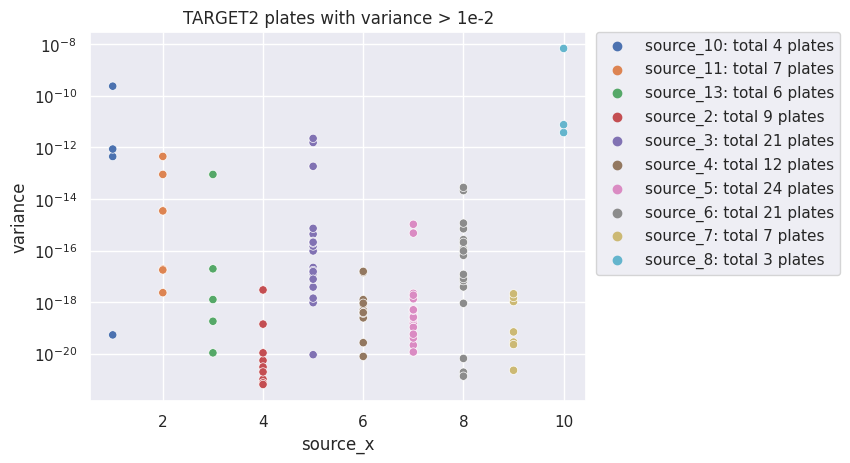

In [33]:
FEA_DIR = "./feature_distances/cellprofiler_sphereMAD_pca"
files = os.listdir(FEA_DIR)
sources = [f.split(".")[0] for f in files if f.endswith(".tsv")]
total_x = []
total_y = []
hue = []
remove_plates = []
for i, (source, f) in enumerate(zip(sources, files)):
    distance = pd.read_csv(os.path.join(FEA_DIR, f), delimiter="\t", header=None)
    batch_stat = {}
    batch = distance[2].unique()
    plate = distance[0].unique()
    print(f"{source}: Total {len(batch)} batchs, {len(plate)} plates")
    selected_plates = 0
    for p in plate:
        plate_distance = distance.loc[distance[0] == p]
        var = np.var(plate_distance[10])  
        if var > 1e-2:
            continue
        else:
            selected_plates += 1
            total_x.append(i+1)
            total_y.append(var)
            print(p)
    hue.extend([source + f": total {selected_plates} plates"] * selected_plates)

import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style="darkgrid")
data = pd.DataFrame({"source_x": total_x, "variance": total_y, "hue": hue})
g = sns.scatterplot(data, x="source_x", y="variance", hue="hue")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.yscale('log')
plt.title("TARGET2 plates with variance > 1e-2")

Total 6 batchs, 6 plates
[5.472532993658511e-20, 32384014387.679554, 4.4456826783973176e-13, 8.665324122138188e-13, 2834158424878.846, 2.3620030772651203e-10]


In [16]:
eu_dist

483373305490.7733

In [14]:
distance

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,Dest210726-160150,source_10,2021_08_03_U2OS_48_hr_run12,JCP2022_043547,"InChI=1S/C8H18O/c1-2-3-4-5-6-7-8-9/h9H,2-8H2,1H3",KBPLFHHGFOOTCA-UHFFFAOYSA-N,CCCCCCCCO,2021_08_03_U2OS_48_hr_run12,A01,D03,27.712813,1.002611,11.081749,1.100807,0.029104,0.006585
1,Dest210726-160150,source_10,2021_08_03_U2OS_48_hr_run12,JCP2022_050797,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,LOUPRKONTZGTKE-UHFFFAOYSA-N,C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12,2021_08_03_U2OS_48_hr_run12,A02,A05,27.712813,1.002611,7.912683,0.742660,0.029177,0.007491
2,Dest210726-160150,source_10,2021_08_03_U2OS_48_hr_run12,JCP2022_050797,InChI=1S/C20H24N2O2/c1-3-13-12-22-9-7-14(13)10...,LOUPRKONTZGTKE-UHFFFAOYSA-N,C=CC1CN2CCC1CC2C(O)c1ccnc2ccc(OC)cc12,2021_08_03_U2OS_48_hr_run12,H12,J12,27.712813,1.002611,9.385450,1.039689,0.024474,0.008897
3,Dest210726-160150,source_10,2021_08_03_U2OS_48_hr_run12,JCP2022_050997,InChI=1S/C6H8O6/c7-1-2(8)5-3(9)4(10)6(11)12-5/...,LPYXWGMUVRGUOY-UHFFFAOYSA-N,OCC(O)c1oc(O)c(O)c1O,2021_08_03_U2OS_48_hr_run12,A03,A05,27.712813,1.002611,10.917785,1.035614,0.030302,0.007909
4,Dest210726-160150,source_10,2021_08_03_U2OS_48_hr_run12,JCP2022_108326,"InChI=1S/C7H6O3/c8-6-4-2-1-3-5(6)7(9)10/h1-4,8...",YGSDEFSMJLZEOE-UHFFFAOYSA-N,O=C(O)c1ccccc1O,2021_08_03_U2OS_48_hr_run12,A04,A05,27.712813,1.002611,10.228189,1.161279,0.032515,0.007747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1913,Dest210823-172450,source_10,2021_08_23_U2OS_48_hr_run18,JCP2022_096067,"InChI=1S/C5H9NS2/c7-5(8)6-3-1-2-4-6/h1-4H2,(H,...",VSWDORGPIHIGNW-UHFFFAOYSA-N,S=C(S)N1CCCC1,2021_08_23_U2OS_48_hr_run18,P19,N19,27.712813,1.002611,10.764273,0.990671,0.009362,0.005397
1914,Dest210823-172450,source_10,2021_08_23_U2OS_48_hr_run18,JCP2022_032357,InChI=1S/C22H26N2O4S/c1-15(25)28-20-21(16-9-11...,HSUGRBWQSSZJOP-UHFFFAOYSA-N,COc1ccc(C2Sc3ccccc3N(CCN(C)C)C(=O)C2OC(C)=O)cc1,2021_08_23_U2OS_48_hr_run18,P20,N20,27.712820,1.002611,8.468503,0.803377,0.016274,0.011456
1915,Dest210823-172450,source_10,2021_08_23_U2OS_48_hr_run18,JCP2022_047545,InChI=1S/C22H22FN5O3/c1-3-20(29)25-16-5-4-6-17...,KXBDTLQSDKGAEB-UHFFFAOYSA-N,C=CC(O)=Nc1cccc(N=c2[nH]c(Nc3ccc(OCCOC)cc3)ncc...,2021_08_23_U2OS_48_hr_run18,P21,N20,27.712815,1.002611,9.186030,0.857407,0.009647,0.006930
1916,Dest210823-172450,source_10,2021_08_23_U2OS_48_hr_run18,JCP2022_043099,"InChI=1S/C13H9F3N2O2/c14-13(15,16)8-3-1-4-9(7-...",JZFPYUNJRRFVQU-UHFFFAOYSA-N,O=C(O)c1cccnc1Nc1cccc(C(F)(F)F)c1,2021_08_23_U2OS_48_hr_run18,P22,P24,27.712817,1.002611,10.347592,1.065010,0.015375,0.011144


In [38]:
import glob
treated_samples = glob.glob("./datasets/treated_moa_target2/treated/*JCPQC018*")[:100]

In [39]:
import h5py 
def load_hdf5(name: str) -> np.ndarray:
    with h5py.File(name, "r") as f:
        data = f["raw_image"][:]
    return data

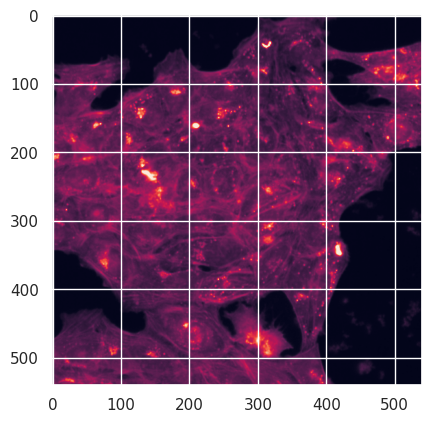

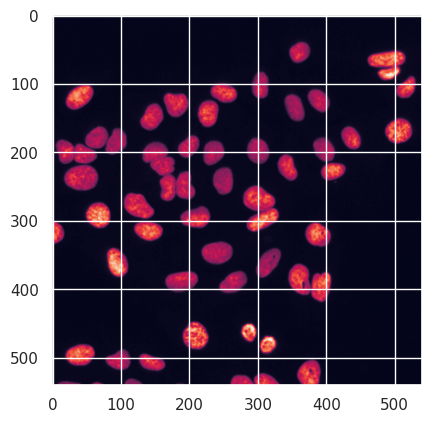

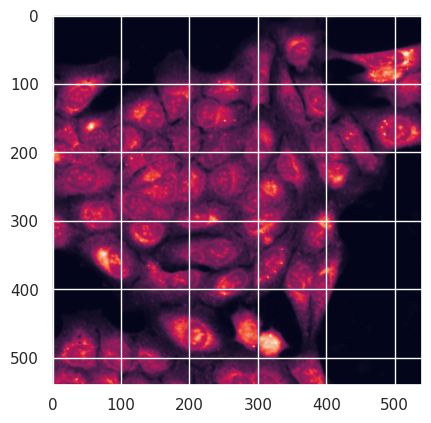

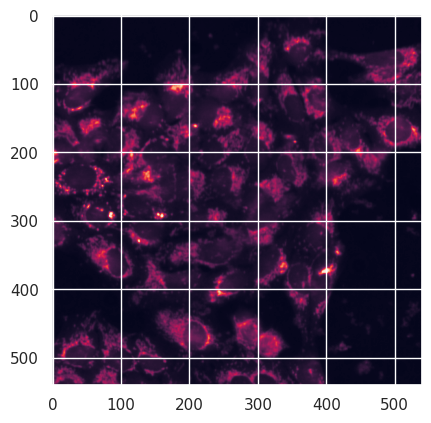

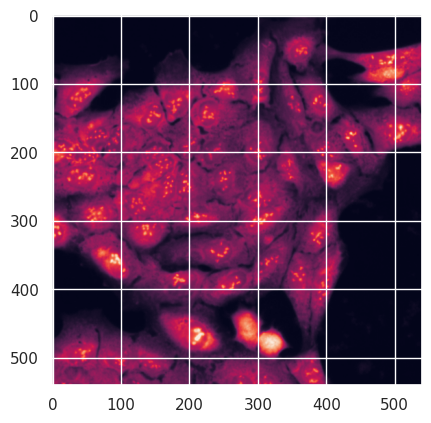

In [41]:
from matplotlib import pyplot as plt
img = load_hdf5(treated_samples[80])
for c in range(5):
    plt.figure()
    plt.imshow(img[:,:,c])

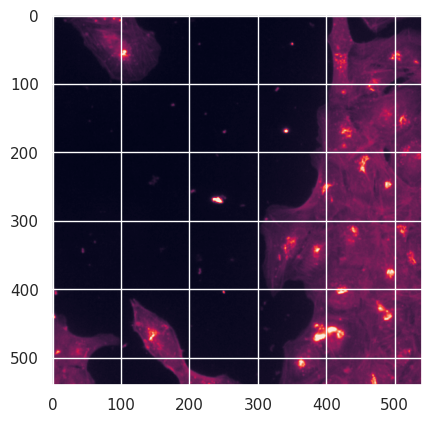

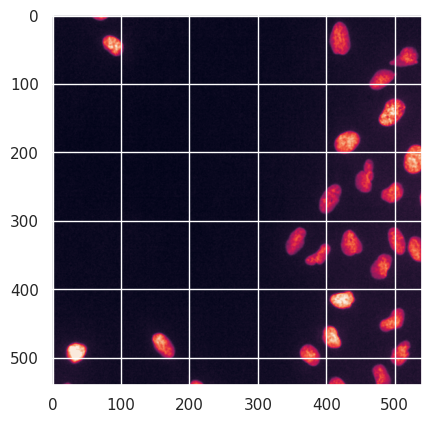

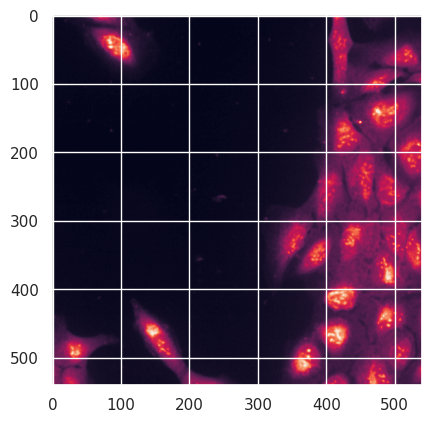

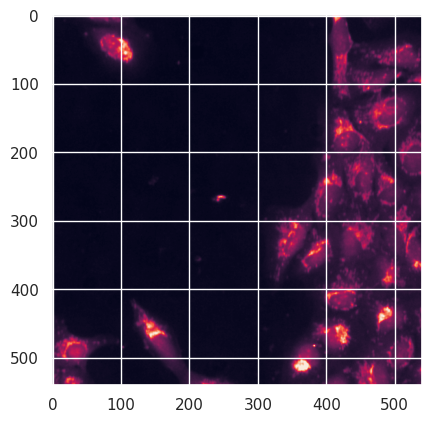

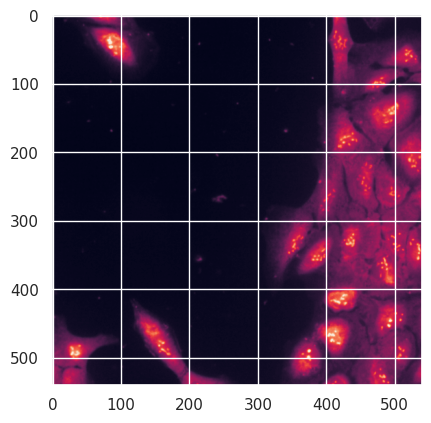

In [44]:
treated_samples = glob.glob("./datasets/treated_moa_target2/treated/*JCPQC038*")[:100]
from matplotlib import pyplot as plt
img = load_hdf5(treated_samples[30])
for c in range(5):
    plt.figure()
    plt.imshow(img[:,:,c])